Populating the interactive namespace from numpy and matplotlib


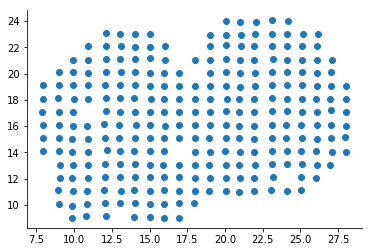

In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('../MouseOB/MOB_final_results.csv', index_col=0)
ms_results = pd.read_csv('../MouseOB/MOB_MS_results.csv', index_col=0)
sample_info = pd.read_csv('../MouseOB/MOB_sample_info.csv', index_col=0)

df = pd.read_csv('../MouseOB/data/Rep11_MOB_0.csv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
df = df.loc[sample_info.index]
dfm = np.log10(df + 1)

plt.scatter(sample_info.x, sample_info.y);

In [2]:
X = sample_info[['x', 'y']]

In [3]:
import SpatialDE

In [4]:
SpatialDE.base.get_l_limits(X)

(0.40200124377918117, 42.954931777387323)

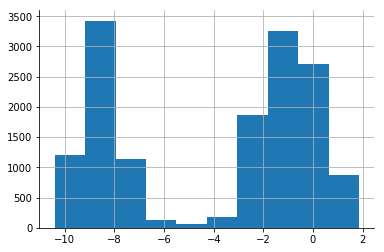

In [5]:
results.max_s2_t_hat.pipe(np.log10).hist()

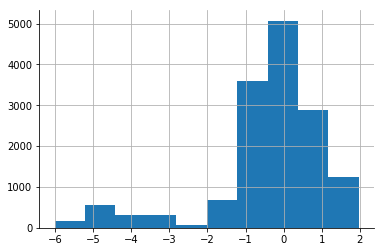

In [6]:
(results.max_s2_t_hat * results.max_delta).pipe(np.log10).hist()

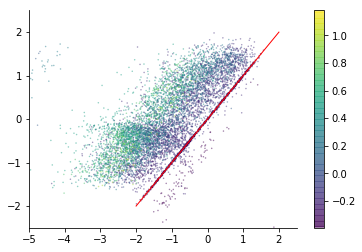

In [7]:
plt.scatter(results.max_s2_t_hat.pipe(np.log10),
            (results.max_s2_t_hat * results.max_delta).pipe(np.log10),
            marker='.',
            c=results.l.pipe(np.log10),
            s=1,
            alpha=0.5)

plt.colorbar()

plt.xlim(-5, 2.5)
plt.ylim(-2.5, 2.5);

plt.plot([-2, 2], [-2, 2], c='r', lw=1);

In [8]:
from scipy import stats

In [9]:
mu = np.array([-0.5, 0.0])
sigma = np.array([[1.0, 0.75],
                  [0.75, 1.0]]);

s = stats.multivariate_normal.rvs(mu, 0.5 * sigma, size=100)

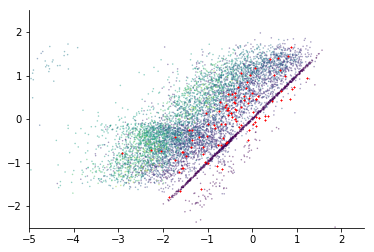

In [10]:
plt.scatter(results.max_s2_t_hat.pipe(np.log10),
            (results.max_s2_t_hat * results.max_delta).pipe(np.log10),
            marker='.',
            c=results.l.pipe(np.log10),
            s=1,
            alpha=0.5)

plt.scatter(s[:, 0], s[:, 1], c='r', s=1, marker='x')

plt.xlim(-5, 2.5)
plt.ylim(-2.5, 2.5);

In [11]:
l_min, l_max = SpatialDE.base.get_l_limits(X)
l_min, l_max = l_min / 2, l_max * 2

In [12]:
sim_expr = pd.DataFrame(index=range(X.shape[0]))
ground_truth = pd.DataFrame(index=['s2_s', 's2_n', 'l'])
j = 0

for l in np.logspace(np.log10(l_min), np.log10(l_max), 15):
    print(l)
    K = SpatialDE.base.SE_kernel(X, l)
    I = np.eye(K.shape[0])
    O = np.zeros(K.shape[0])
    for si in 10 ** s:
        KI = si[0] * K + si[1] * I
        
        gex = stats.multivariate_normal.rvs(O, KI)
        
        sim_expr[j] = gex
        ground_truth[j] = [si[0], si[1], l]
        
        j += 1
        
ground_truth = ground_truth.T
ground_truth['FSV'] = ground_truth.s2_s / (ground_truth.s2_s + ground_truth.s2_n)

0.20100062189
0.30982392107
0.477565000369
0.736122403946
1.13466479573
1.74898113651
2.69589311962
4.15547061125
6.40527470295
9.87314021887
15.2185350827
23.4579682786
36.1582946564
55.7346764619
85.9098635548


In [13]:
results = SpatialDE.run(X, sim_expr)
results.loc[results.pval < 1e-16, 'pval'] = 1e-16

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.1s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                             
INFO:root:Model 3 of 10                             
INFO:root:Model 4 of 10                             
INFO:root:Model 5 of 10                             
INFO:root:Model 6 of 10                             
INFO:root:Model 7 of 10                             
INFO:root:Model 8 of 10                             
INFO:root:Model 9 of 10                             
INFO:root:Model 10 of 10                            


In [14]:
results = results.sort_values('g')

In [15]:
results.head().T

,0,1,2,418,970
FSV,2.0597e-09,2.0597e-09,2.0597e-09,0.00119355,0.000222527
M,4,4,4,4,4
g,0,1,2,3,4
l,0.402001,0.402001,0.402001,0.675535,3.2056
max_delta,4.85165e+08,4.85165e+08,4.85165e+08,831.402,3737.7
max_ll,-739.997,-299.017,-633.067,-399.994,-370.642
max_mu_hat,0.186178,-0.00144106,-0.0852865,0.01648,-0.0335927
max_s2_t_hat,3.58617e-08,1.20385e-09,1.57382e-08,0.001526,0.000271329
model,SE,SE,SE,SE,SE
n,260,260,260,260,260


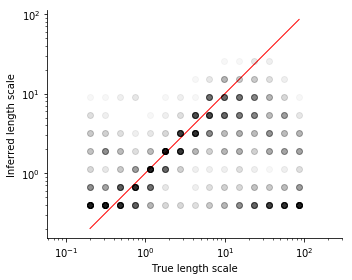

In [19]:
figsize(5, 4)
plt.loglog()
plt.plot([l_min, l_max], [l_min, l_max], c='r', lw=1, zorder=-1)
plt.scatter(ground_truth.l, results.l, alpha=0.03, c='k');
plt.axis('equal');
plt.xlabel('True length scale')
plt.ylabel('Inferred length scale');

plt.tight_layout()
plt.savefig('model_simulation_lengthscales.pdf', bbox_inches='tight')

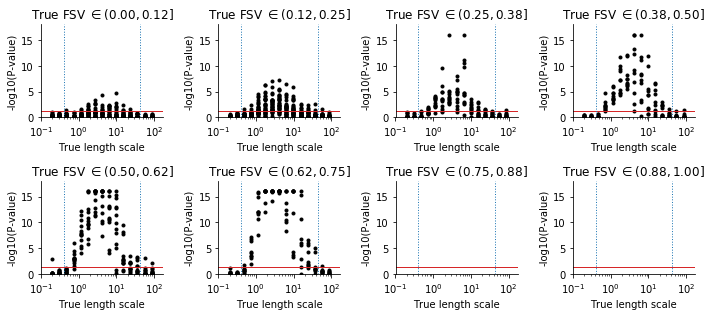

In [18]:
figsize(10, 4.5)
N = 8
irvl = np.linspace(0, 1, N + 1)
for i in range(N):
    i0, i1 = irvl[i], irvl[i+1]
    gt_part = ground_truth.query('@i0 < FSV <= @i1')
    res_part= results.query('g in @gt_part.index')
    
    plt.subplot(2, N // 2, i + 1)
    
    plt.xscale('log')
    plt.scatter(gt_part.l,
                -np.log10(res_part.pval),
                c='k',
                marker='.');

    plt.axhline(-np.log10(0.05), lw=1, c='tab:red');
    plt.axvline(l_min * 2, c='tab:blue', lw=1, ls=':')
    plt.axvline(l_max / 2, c='tab:blue', lw=1, ls=':')
    
    plt.ylim(0, 18)
    plt.xlim(l_min / 2, l_max * 2)
    
    plt.title('True FSV $\in ({:.2f}, {:.2f}]$'.format(i0, i1))
    plt.xlabel('True length scale')
    plt.ylabel('-log10(P-value)')
    
plt.tight_layout()
plt.savefig('model_simulation.pdf', bbox_inches='tight')